In [1]:
import numpy as np
import matplotlib.pyplot as plt

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import *
from implementations import *
from preprocessing import *

In [14]:
Seed = 42
np.random.seed(42)

## Load the Data

In [3]:
p = Preprocessing(load_csv('../dataset/trainset.csv'))
y_train , x_train= p.preprocess()
p = Preprocessing(load_csv('../dataset/testset.csv'))
y_test, x_test = p.preprocess()

In [4]:
print(x_train.shape)
print(x_test.shape)


(225000, 31)
(25000, 31)


## Logistic predictions from weights

In [5]:
def predict(weight, x_test):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = sigmoid(x_test.dot(weight))
    
    f = lambda x : 0 if x <0.5 else 1
    
    predictions = np.array([ f(x) for x in pred])
    
    return predictions

## Cross Validation, Calculation of the Accuracy 

In [6]:
def K_Cross_Validation(xt_training, y_training, K, initial_w, max_iters, _lambda, gamma, batch_size):
    """
    #K_Cross_Validation training technique
    
    :param xt_training: extended feature matrix 
    :type xt: numpy 2D array
    
    :param y_training: labels
    :type y_training: 1D array
    
    :param K: number of folds
    :type K: int
    
    :param initial_w: initial value of weights
    :type initial_w: numpy 1D array
    
    :param max_iters: the number of maximal iterations
    :type max_iters: int
    
    :param _lambda: regularizer
    :type _lambda: float64
    
    :param gamma: learning rate
    :type gamma: float64
    
    :param batch_size: size of the batch for batch_reg_logistic_regression
    :type batch_size: int
    
    :return: accuracy, validation_weights, accuracy_mean, weights_mean
    :rtype:  1D numpy array,  (K,xt_training.shape[1])numpy array,  float64, 1D numpy array
    
    """

    #Initialization of all needed arrays
    validation_loss = np.zeros(K)
    validation_weights = np.zeros((K,xt_training.shape[1]))
    accuracy = np.zeros(K)
    indices = np.linspace(0, len(y_training)-1 , K+1 ,dtype=int) #no need to randomize, split of test/train shuffled the data
    
    for i in range(K):
        #Split de data 
        x_cross_test = xt_training[indices[i] : indices[i+1], :]
        y_cross_test = y_training[indices[i] : indices[i+1]]
        x_cross_train = np.concatenate((xt_training[:indices[i], :], xt_training[indices[i]:, :]),axis=0)
        y_cross_train = np.concatenate((y_training[:indices[i]], y_training[indices[i]:]),axis=0)
        
        #Run Reg_Logistric_Regression on the obtained datasets
        validation_weights[i], validation_loss[i] = logistic_regression(y_cross_train, x_cross_train, initial_w, max_iters, gamma)
        #Calculate predictions of the model
        predictions = predict(validation_weights[i] , x_cross_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_cross_test) / len(y_cross_test)
        
    return accuracy, validation_weights, np.mean(accuracy), np.mean(validation_weights, axis=0)
        

C:\Users\thoma\School\Machine_learning\ML-Project1\helpers\implementation_helpers.py:89: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


0.7353276973297579


{'whiskers': [<matplotlib.lines.Line2D at 0x24692dac7c8>,
 'caps': [<matplotlib.lines.Line2D at 0x24692dacec8>,
 'boxes': [<matplotlib.lines.Line2D at 0x246ff717a08>],
 'medians': [<matplotlib.lines.Line2D at 0x24694c79f08>],
 'fliers': [<matplotlib.lines.Line2D at 0x24694c79c08>],
 'means': []}

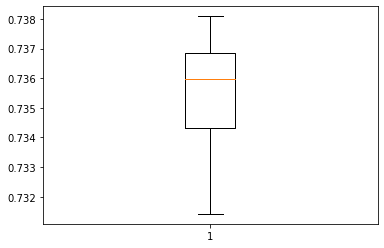

In [7]:
acc, weights, mean_acc, mean_weights= K_Cross_Validation(x_train, y_train, 10, np.zeros(x_train.shape[1]), 20, 0, 0.03, 10000)
print(mean_acc)
plt.boxplot(acc)


## Test of the model with the mean of weights obtained with Cross Validation

In [8]:
def Accuracy_On_Test_Set(w, x_test, y_test):     
    #Test the trained model on test set
    predictions = predict(w , x_test)
    accuracy = np.sum(predictions == y_test) / len(y_test)
    
    return accuracy

Accuracy_On_Test_Set(mean_weights, x_test, y_test)

C:\Users\thoma\School\Machine_learning\ML-Project1\helpers\implementation_helpers.py:89: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


0.73436

## Trying to tune the gamma parameter

[1.0000e-07 1.1112e-03 2.2223e-03 3.3334e-03 4.4445e-03 5.5556e-03
 6.6667e-03 7.7778e-03 8.8889e-03 1.0000e-02]
1e-07 0.7115898283171724


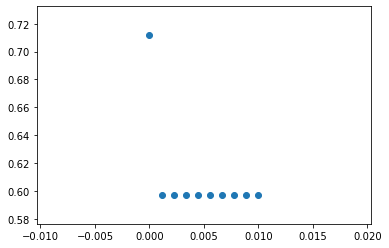

In [9]:
def Tune_Gamma(xt_training, y_training, K, gamma_range, initial_w, max_iters, batch_size=None):
        
    gammas = np.linspace(0.0000001, gamma_range, 10)
    print(gammas)
    max_acc = 0
    opt_lambda = 0
    accuracies = []
    for i, gamma in enumerate(gammas):
       
        accuracy = K_Cross_Validation(xt_training, y_training, K, initial_w, max_iters, None, gamma, None)[2]
        accuracies.append([gamma,accuracy])
        if (accuracy > max_acc):
            max_acc = accuracy
            opt_gamma = gamma
                
    return opt_gamma , max_acc, np.array(accuracies)
opt_gamma, max_acc, accuracies = Tune_Gamma(xt_training=x_train, y_training=y_train, K= 5, gamma_range=0.01, initial_w=np.zeros(x_train.shape[1]), max_iters= 50)
accuracies = np.array(accuracies)
plt.scatter(accuracies[:,0],accuracies[:,1])
print(opt_gamma, max_acc)

## Train on full trainset with optimal Hyperparemeters & predict on testset

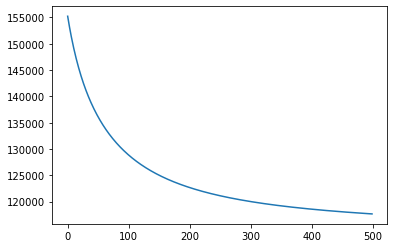

In [15]:
opt_w, losses = logistic_regression(y_train, x_train, np.zeros(x_train.shape[1]), 500, opt_gamma, all_losses=True)
plt.plot(losses)

In [16]:
opt_w

array([-6.77116449e-01, -1.71868553e-02, -5.24547856e-01, -8.80801782e-02,
        1.49366902e-01,  1.11535731e-01,  1.42943046e-01, -5.98279594e-02,
        2.67375660e-01, -9.47725319e-02,  6.30147441e-02, -2.19275012e-01,
        2.83069447e-01,  1.59029188e-01,  2.96787985e-01, -2.48713536e-03,
       -5.76578896e-03,  8.75457249e-02, -1.87396255e-03,  4.05582121e-03,
       -1.06042718e-02,  5.12151770e-03,  1.59108189e-03,  1.76415126e-02,
       -8.08769042e-03, -2.70831471e-04,  7.94094607e-04, -9.80615826e-02,
        1.98512308e-03, -5.99622733e-04, -1.31456954e-02])

In [13]:
p = predict(opt_w, x_test)
print(f"accuracy={(p==y_test).mean()}")

accuracy=0.73668


optimal lambda value is very very low, so we can see that the model is most likely underfitting the dataset..
**IN  LOGISTIC REGRESSION, LAMBDA HAS NOTHING TO DO WITH OVERFITTING**


however, the test and train scores are ver close & the cross-scores are also close --> no overfitting

## Make prediction File for submission

In [ ]:
p = Preprocessing(load_csv('../dataset/test.csv'))
ids, tx = p.preprocess(labeled=False)


In [ ]:
p = predict(w,tx)


In [ ]:
ids.shape

In [ ]:
create_csv_submission(ids, p, "model_0001.csv")